In [1]:
import h5py
import numpy as np

In [2]:
lbp = {}

with h5py.File("lbp_feat_v2.h5", "r") as f:
    for k in list(f.keys()):
        lbp[k] = np.array(f[k])

In [3]:
ncm = {}

with h5py.File("ncm_feat.h5", "r") as f:
    for k in list(f.keys()):
        ncm[k] = np.array(f[k])

In [4]:
output = {}
with open("final_keys.txt", "r") as f:
    for l in f.readlines():
        a = l.split("\t")
        output[a[0]] = int(a[1])

In [5]:
trainKeys = []
with open("trainKeys2.txt", "r") as f:
    trainKeys = [l[:-1] for l in f.readlines()]

testKeys = []
with open("testKeys2.txt", "r") as f:
    testKeys = [l[:-1] for l in f.readlines()]

len(trainKeys), len(testKeys)

(783, 198)

In [6]:
finalFeat = {}

for k in output:
    finalFeat[k] = np.concatenate((lbp[k], ncm[k]), axis=0)

len(finalFeat)

981

# SVM (One vs All)

In [7]:
from sklearn import svm
from imblearn.over_sampling import SMOTE

In [8]:
svms = [svm.SVC(kernel='rbf') for _ in range(7)]

In [9]:
for i in range(7):
    X = []
    y = []
    for k in trainKeys:
        X.append(finalFeat[k])
        if output[k] == i:
            y.append(1)
        else:
            y.append(0)
            
    X = np.array(X)
    y = np.array(y)
    
    X_resampled, y_resampled = SMOTE().fit_resample(X, y)
    
    svms[i].fit(X_resampled, y_resampled)

In [10]:
pred = {}

for k in testKeys:
    p = []

    for i in range(7):
        p.append(svms[i].decision_function([finalFeat[k]]))

    p = np.array(p)
    pred[k] = np.argmax(p)

In [11]:
with open("predictions2.txt", "w") as f:
    for k in pred:
        f.write(k+"\t"+str(pred[k])+"\n")

In [12]:
c = 0

for k in pred:
    if pred[k] == output[k]:
        c += 1
        
print("Accuracy:",round(c*100/len(pred),2))

Accuracy: 64.65


In [13]:
emotions = {0:'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'sadness',
 6: 'surprise'}

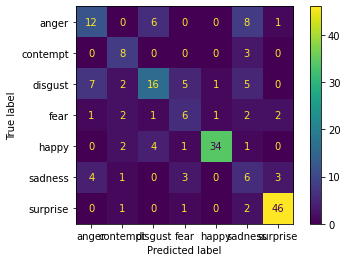

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for k in pred:
    y_true.append(emotions[output[k]])
    y_pred.append(emotions[pred[k]])
    

dispLabels = ['anger',
'contempt',
'disgust',
'fear',
'happy',
'sadness',
'surprise']
    
cm = confusion_matrix(y_true, y_pred, labels=dispLabels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dispLabels)
disp.plot()